#**Exploratory Data Analysis of Road Accidents in Victoria**
Understanding road accidents is crucial for improving traffic safety and reducing fatalities. This exploratory data analysis (EDA) aims to uncover patterns, trends, and key factors contributing to road accidents in Victoria. By leveraging historical accident data, we will analyze variables such as time, location, weather conditions, and severity to identify potential risk factors. The insights gained from this analysis can help inform policy decisions, enhance road safety measures, and support data-driven interventions.

This notebook will include:

Data cleaning and preprocessing
Summary statistics and visualizations
Spatial and temporal analysis of accident hotspots
Identification of significant factors influencing accident severity
Let's begin by loading and inspecting the dataset.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

###Loading the datasets

In [10]:
accident=pd.read_csv('accident.csv')
vehicle=pd.read_csv('vehicle.csv')
atmosphere=pd.read_csv('atmospheric_cond.csv')

In [4]:
accident.head()

,ACCIDENT_NO,ACCIDENT_DATE,ACCIDENT_TIME,ACCIDENT_TYPE,ACCIDENT_TYPE_DESC,DAY_OF_WEEK,DAY_WEEK_DESC,DCA_CODE,DCA_DESC,LIGHT_CONDITION,...,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_NOT_INJ,NO_PERSONS,POLICE_ATTEND,ROAD_GEOMETRY,ROAD_GEOMETRY_DESC,SEVERITY,SPEED_ZONE,RMA
0,T20120000046,2012-01-01,16:25:00,2,Struck Pedestrian,1,Sunday,102,FAR SIDE. PED HIT BY VEHICLE FROM THE LEFT,1,...,0,1,1,2,1,2,T intersection,3,60,Arterial Other
1,T20120000062,2012-01-01,18:00:00,4,Collision with a fixed object,1,Sunday,173,RIGHT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,1,...,1,0,0,1,1,5,Not at intersection,2,100,NaN
2,T20120000060,2012-01-01,19:40:00,6,Vehicle overturned (no collision),1,Sunday,184,OUT OF CONTROL ON CARRIAGEWAY (ON BEND),1,...,1,0,0,1,1,2,T intersection,2,60,Local Road
3,T20120000009,2012-01-01,02:25:00,4,Collision with a fixed object,1,Sunday,171,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,5,...,0,2,0,2,1,5,Not at intersection,3,100,Arterial Other
4,T20120000059,2012-01-01,18:05:00,4,Collision with a fixed object,1,Sunday,171,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,1,...,2,0,0,2,1,5,Not at intersection,2,100,Arterial Highway


In [5]:
accident.shape

(178695, 23)

In [6]:
accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178695 entries, 0 to 178694
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   ACCIDENT_NO         178695 non-null  object
 1   ACCIDENT_DATE       178695 non-null  object
 2   ACCIDENT_TIME       178695 non-null  object
 3   ACCIDENT_TYPE       178695 non-null  int64 
 4   ACCIDENT_TYPE_DESC  178695 non-null  object
 5   DAY_OF_WEEK         178695 non-null  int64 
 6   DAY_WEEK_DESC       178695 non-null  object
 7   DCA_CODE            178695 non-null  int64 
 8   DCA_DESC            178695 non-null  object
 9   LIGHT_CONDITION     178695 non-null  int64 
 10  NODE_ID             178695 non-null  int64 
 11  NO_OF_VEHICLES      178695 non-null  int64 
 12  NO_PERSONS_KILLED   178695 non-null  int64 
 13  NO_PERSONS_INJ_2    178695 non-null  int64 
 14  NO_PERSONS_INJ_3    178695 non-null  int64 
 15  NO_PERSONS_NOT_INJ  178695 non-null  int64 
 16  NO

###Converting ACCIDENT_DATE and ACCIDENT_TIME to type datetime

In [11]:
accident['ACCIDENT_DATE'] = pd.to_datetime(accident['ACCIDENT_DATE'] + ' ' + accident['ACCIDENT_TIME'])

In [15]:
#We don't need the Accident Time feature anymore
accident.drop(columns=['ACCIDENT_TIME'],inplace=True)

###Checking for missing values and duplicates

In [20]:
accident.isna().sum()

,0
ACCIDENT_NO,0
ACCIDENT_DATE,0
ACCIDENT_TYPE,0
ACCIDENT_TYPE_DESC,0
DAY_OF_WEEK,0
DAY_WEEK_DESC,0
DCA_CODE,0
DCA_DESC,0
LIGHT_CONDITION,0
NODE_ID,0


In [21]:
accident.duplicated().sum()

0

## **No missing values or duplicates :)**

### We can Reduce Dimensionality by Merging Similar Columns
* DAY_OF_WEEK and DAY_WEEK_DESC → Keep DAY_WEEK_DESC (more interpretable)
* ACCIDENT_TYPE and ACCIDENT_TYPE_DESC → Keep ACCIDENT_TYPE_DESC
* ROAD_GEOMETRY and ROAD_GEOMETRY_DESC → Keep ROAD_GEOMETRY_DESC
* DCA_CODE and DCA_DESC → Keep DCA_DESC (descriptive)

In [22]:
accident.drop(['DAY_OF_WEEK', 'ACCIDENT_TYPE', 'ROAD_GEOMETRY', 'DCA_CODE'], axis=1, inplace=True)


## Aggregate Injury Data
The dataset has multiple injury columns:

* NO_PERSONS_INJ_2 (Minor)
* NO_PERSONS_INJ_3 (Serious)
* NO_PERSONS_NOT_INJ

We can sum minor and serious injuries into a Total Injuries column:

In [24]:
accident['TOTAL_INJURIES'] = accident['NO_PERSONS_INJ_2'] + accident['NO_PERSONS_INJ_3']

# To understand accident trends, we can visualize distributions:

#**Univariate Analysis**

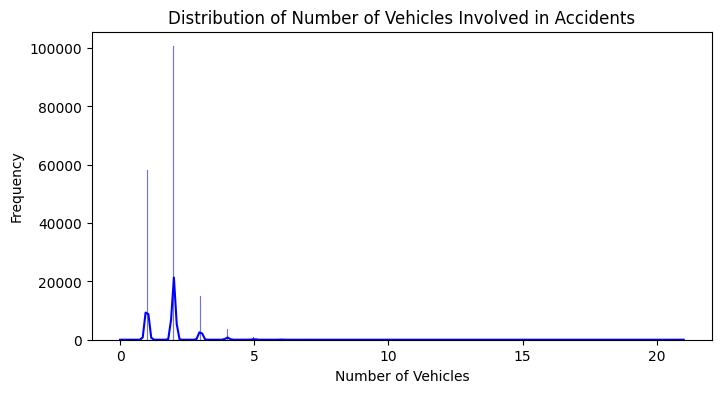

In [34]:
# Histogram for 'NO_OF_VEHICLES'
plt.figure(figsize=(8, 4))
sns.histplot(accident['NO_OF_VEHICLES'], kde=True, color='blue')
plt.title('Distribution of Number of Vehicles Involved in Accidents')
plt.xlabel('Number of Vehicles')
plt.ylabel('Frequency')
plt.show()



### Analysis of the Number of Vehicles Involved in Accidents

The histogram above illustrates the distribution of the number of vehicles involved in road accidents. Several key observations can be drawn from this visualization:

**High Frequency of Single-Vehicle Incidents:** The most prominent peak at the very beginning of the histogram indicates that accidents involving only one vehicle are by far the most common. This might suggest a prevalence of single-vehicle incidents such as collisions with stationary objects or rollovers.

**Multiple Vehicle Accidents:** There are smaller peaks for two and three vehicles, which gradually decrease in frequency as the number of vehicles increases. This indicates that accidents involving multiple vehicles are less common, but still significant, especially for accidents involving two vehicles.

**Rare Large Multi-Vehicle Accidents:** Incidents involving more than three vehicles are increasingly rare, as indicated by the very low frequency of accidents with four or more vehicles. These occurrences are notable as they typically represent more complex and severe accidents.

**Data Integrity and Accuracy:** The presence of a peak at zero may need further investigation. Typically, an accident would involve at least one vehicle, so a zero value might indicate missing or improperly recorded data.



In [38]:
#Checking for accidents where no cars are involved
accident[accident.NO_OF_VEHICLES==0]

,ACCIDENT_NO,ACCIDENT_DATE,ACCIDENT_TYPE_DESC,DAY_WEEK_DESC,DCA_DESC,LIGHT_CONDITION,NODE_ID,NO_OF_VEHICLES,NO_PERSONS_KILLED,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_NOT_INJ,NO_PERSONS,POLICE_ATTEND,ROAD_GEOMETRY_DESC,SEVERITY,SPEED_ZONE,RMA,TOTAL_INJURIES
118930,T20200008868,2020-05-02 01:45:00,Vehicle overturned (no collision),Saturday,OUT OF CONTROL ON CARRIAGEWAY (ON STRAIGHT),5,47324,0,0,1,0,0,1,1,T intersection,2,110,Local Road,1
120930,T20200012731,2020-07-01 18:50:00,Vehicle overturned (no collision),Wednesday,OUT OF CONTROL ON CARRIAGEWAY (ON STRAIGHT),2,47711,0,0,1,0,0,1,1,T intersection,2,110,Arterial Other,1
141716,T20220002330,2022-02-03 20:05:00,Collision with a fixed object,Thursday,RIGHT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,2,703811,0,0,0,1,0,1,1,T intersection,3,40,Local Road,1
150492,T20230027118,2022-08-30 12:20:00,Vehicle overturned (no collision),Tuesday,OUT OF CONTROL ON CARRIAGEWAY (ON STRAIGHT),1,787871,0,0,1,0,0,1,1,Not at intersection,2,110,Arterial Highway,1
171062,T20230030888,2023-12-29 18:52:00,Vehicle overturned (no collision),Friday,OUT OF CONTROL ON CARRIAGEWAY (ON STRAIGHT),1,795866,0,0,0,1,0,1,1,Not at intersection,3,110,Arterial Other,1


###0 vehicles signifies that there was no collision between two or more vehicles

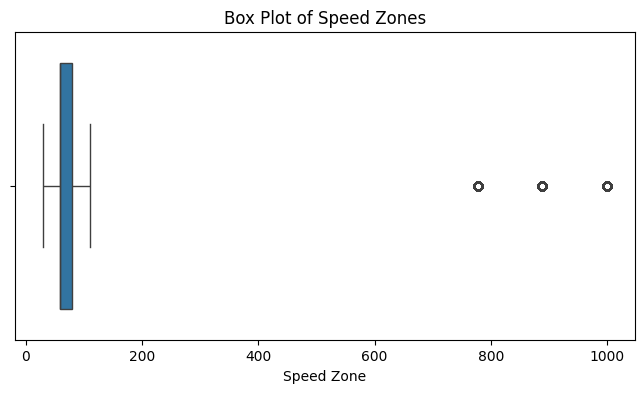

In [33]:
# Boxplot for 'SPEED_ZONE'
plt.figure(figsize=(8, 4))
sns.boxplot(x=accident['SPEED_ZONE'])
plt.title('Box Plot of Speed Zones')
plt.xlabel('Speed Zone')
plt.show()


Central Tendency and Spread: The median speed zone is around 60 km/h, as indicated by the line within the box. The interquartile range (spanning from approximately 50 km/h to 100 km/h) shows the middle 50% of data, suggesting that most accidents occur within these speed limits.

###Since there are a few outliers that may be mis labelled, we are going to deal with them

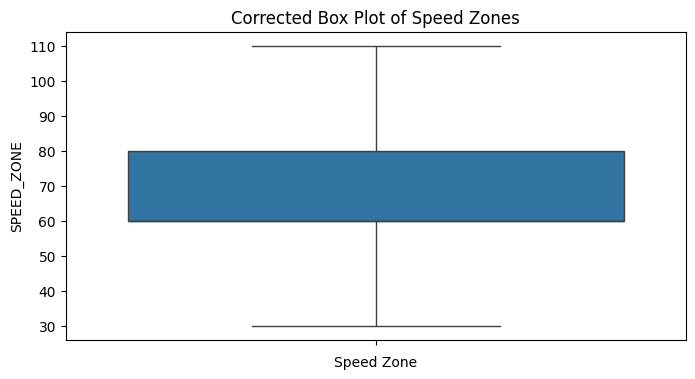

In [36]:
#Capping the values at a maximum plausible limit
accident['SPEED_ZONE'] = accident['SPEED_ZONE'].apply(lambda x: 110 if x > 110 else x)

# Re-plotting to check the changes

plt.figure(figsize=(8, 4))
sns.boxplot(accident['SPEED_ZONE'])
plt.title('Corrected Box Plot of Speed Zones')
plt.xlabel('Speed Zone')
plt.show()

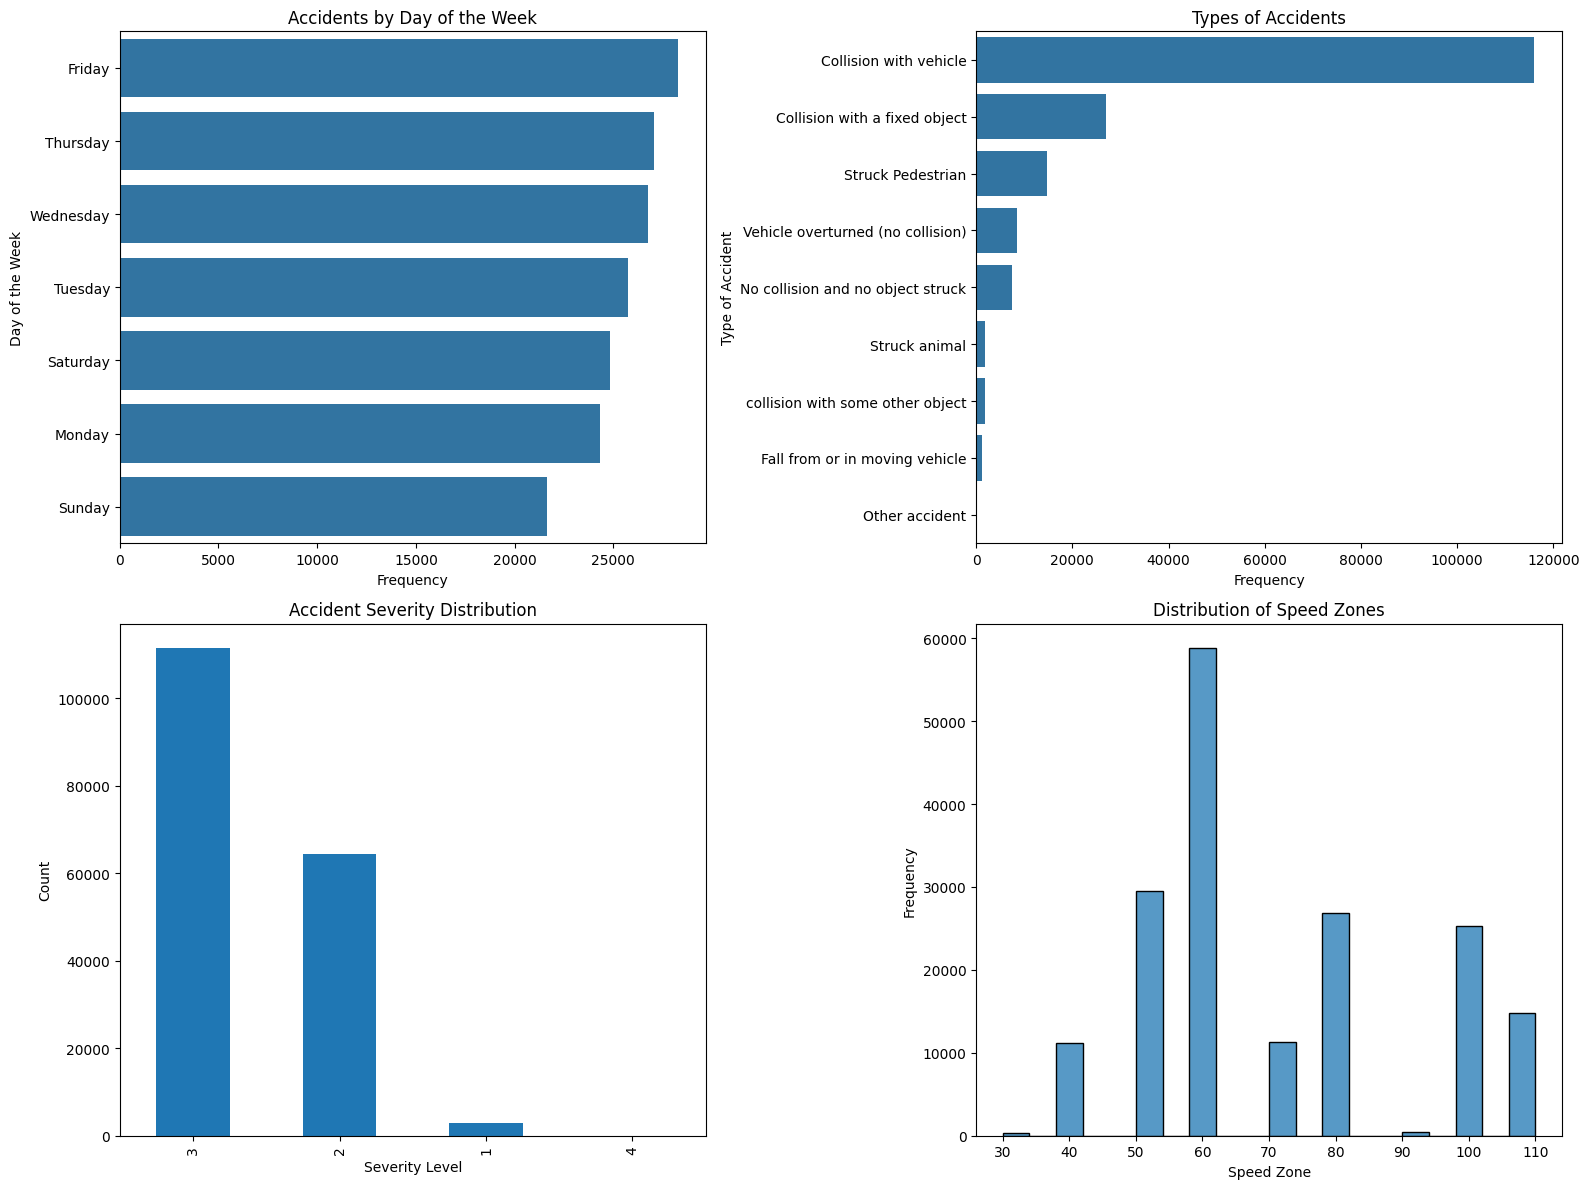

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the figure layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Day of the Week Analysis
sns.countplot(y=accident['DAY_WEEK_DESC'], order=accident['DAY_WEEK_DESC'].value_counts().index, ax=axes[0, 0])
axes[0, 0].set_title('Accidents by Day of the Week')
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].set_ylabel('Day of the Week')

# Accident Type Analysis
sns.countplot(y=accident['ACCIDENT_TYPE_DESC'], order=accident['ACCIDENT_TYPE_DESC'].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_title('Types of Accidents')
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_ylabel('Type of Accident')

# Severity Analysis
accident['SEVERITY'].value_counts().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Accident Severity Distribution')
axes[1, 0].set_xlabel('Severity Level')
axes[1, 0].set_ylabel('Count')

# Speed Zone Analysis
sns.histplot(accident['SPEED_ZONE'], bins=20, kde=False, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Speed Zones')
axes[1, 1].set_xlabel('Speed Zone')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Accidents by Day of the Week

The bar chart shows the frequency of accidents by day of the week. It is evident that Friday experiences the highest number of accidents, followed closely by Thursday and Wednesday. The trend suggests that accident rates increase during the latter part of the workweek. Lower accident rates on weekends, particularly Sunday, might be attributed to reduced commuter traffic and fewer vehicles on the road.

#### Types of Accidents

This visualization categorizes the accidents by type. The most common type of accident is 'Collision with vehicle', which far exceeds other types. This is followed by 'Collision with a fixed object' and 'Struck Pedestrian', indicating significant risks associated with stationary objects and pedestrian areas. Less frequent but notable are incidents like 'Vehicle overturned (no collision)' and 'No collision and no object struck', which include cases where vehicles lose control without making physical contact with another object.

#### Accident Severity Distribution

The histogram for accident severity shows that most accidents fall into the lower severity category (labeled as '2'), suggesting minor damages or injuries. The frequency of more severe accidents (severity '3') is substantially lower, which implies that fatal or major accidents are less common.

#### Distribution of Speed Zones

The distribution of speed zones where accidents occurred reveals a significant concentration in the 60 km/h zone, which likely correlates with urban speed limits where traffic density is high. Other zones, such as 50 km/h and 70 km/h, also show notable accident frequencies, potentially indicating other common urban and suburban speed regulations.




#**Bivariate Analysis**

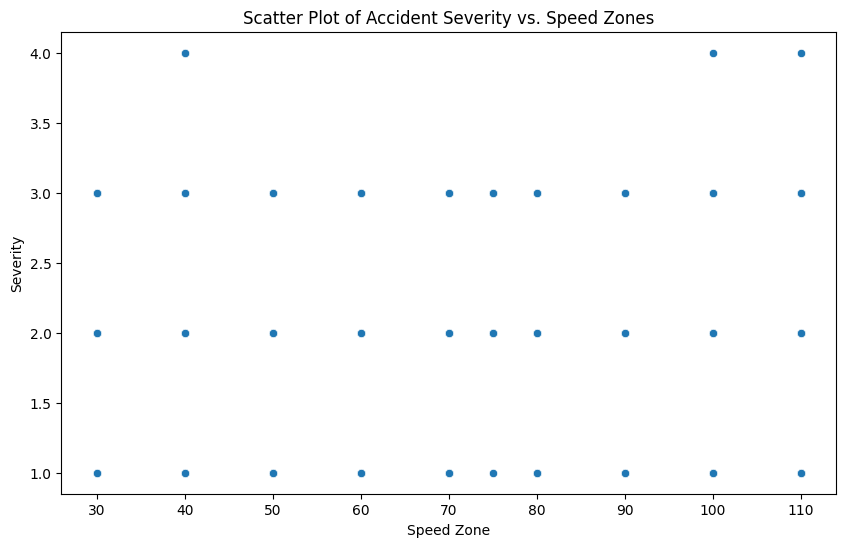

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='SPEED_ZONE', y='SEVERITY', data=accident)
plt.title('Scatter Plot of Accident Severity vs. Speed Zones')
plt.xlabel('Speed Zone')
plt.ylabel('Severity')
plt.show()

### From the scatter plot, there doesn't appear to be a clear linear correlation between accident severity and speed zones. The points are fairly scattered and do not show a distinct trend that would indicate a direct relationship. This suggests that while speed zone might influence the outcome of an accident, it's not a straightforward predictor of accident severity on its own. Other factors likely play significant roles and may interact with speed to impact the severity of accidents.

we could perform statistical tests, such as Spearman's rank correlation, which is better suited for non-linear relationships and can handle ordinal categorical data if the severity is considered an ordinal variable.


In [43]:
spearman_corr = accident['SPEED_ZONE'].corr(accident['SEVERITY'], method='spearman')
print("Spearman's rank correlation coefficient:", spearman_corr)

Spearman's rank correlation coefficient: -0.06130667986291621


Since the correlation is very weak, considering multivariate regression or decision tree models could help identify combinations of factors that significantly affect accident severity.

# Day of the Week vs. Types of Accidents

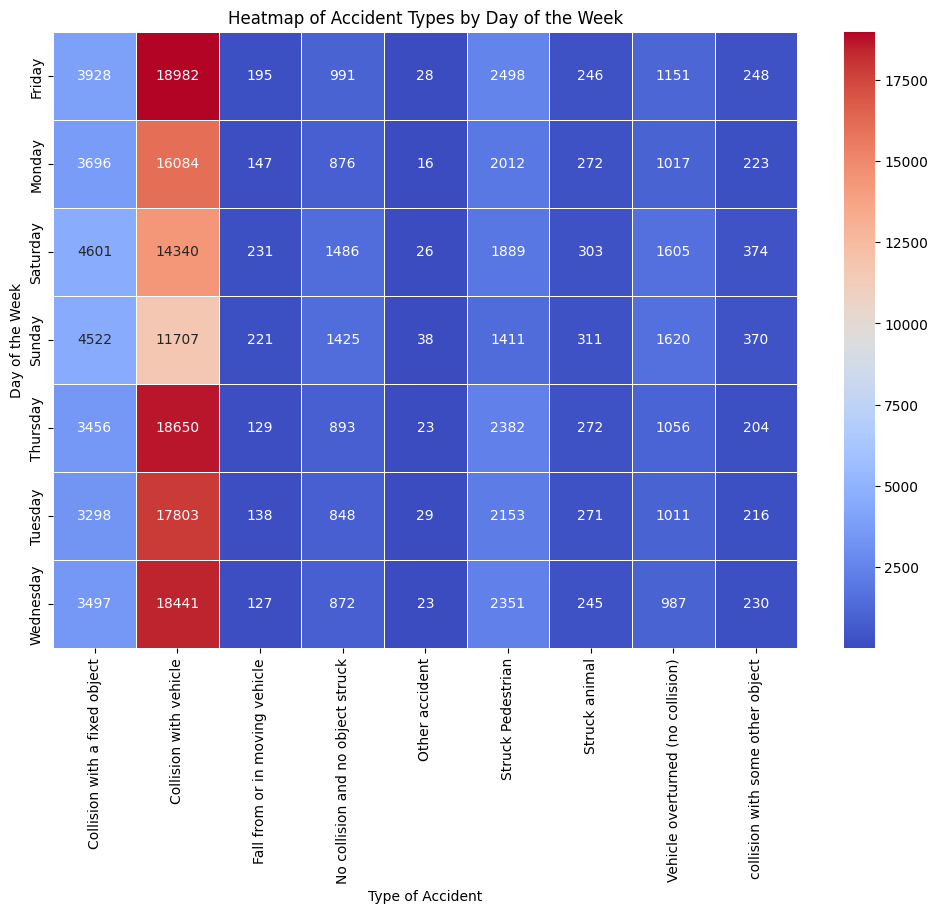

In [44]:

# Creating a pivot table
pivot_table = pd.pivot_table(accident, values='ACCIDENT_NO', index='DAY_WEEK_DESC', columns='ACCIDENT_TYPE_DESC', aggfunc='count', fill_value=0)

# Plotting a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Accident Types by Day of the Week')
plt.xlabel('Type of Accident')
plt.ylabel('Day of the Week')
plt.show()

### Heatmap Analysis of Accident Types by Day of the Week

This heatmap provides a detailed visual representation of the frequency of different types of road accidents across various days of the week. Each cell's color intensity corresponds to the number of accidents, with warmer colors representing higher frequencies. Several key insights can be drawn from this analysis:

#### Key Observations:
- **Collision with Vehicle:** The most frequent type of accident, especially pronounced on Fridays, where the frequency reaches its peak. This suggests that the end of the workweek might have higher traffic volumes or more aggressive driving behaviors, leading to more vehicle collisions.
  
- **Collision with a Fixed Object:** This type of accident also shows a high frequency, particularly on Thursdays and Fridays, indicating possible factors such as fatigue or decreased attention levels towards the week's end.

- **Struck Pedestrian:** Interestingly, accidents involving pedestrians tend to be more frequent towards the beginning and the middle of the week, with a notable increase on Tuesdays. This pattern may reflect variations in pedestrian activity or traffic conditions on these days.

- **No Collision and No Object Struck (e.g., vehicle overturned without a collision):** Such incidents are comparatively less frequent but show a slight increase on Saturdays, which could be related to recreational travel or activities that might involve riskier driving in less congested conditions.

#### Implications for Road Safety:
- **Targeted Safety Measures:** The findings suggest that road safety campaigns and enforcement measures could be more effective if they are specifically tailored to address the most common accident types on the days they are most likely to occur. For example, increasing surveillance and control on Fridays might reduce the high incidence of collisions with other vehicles.
  
- **Public Awareness Programs:** Awareness campaigns could focus on pedestrian safety on Tuesdays, possibly adjusting signal timings or enhancing crosswalk visibility to protect pedestrians.





#Accident Severity vs. Day of the Week

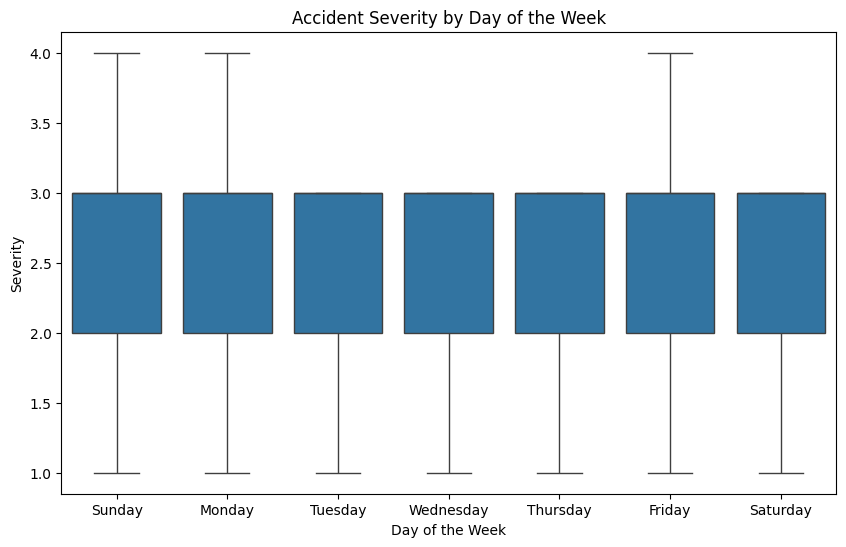

In [46]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='DAY_WEEK_DESC', y='SEVERITY', data=accident, order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.title('Accident Severity by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Severity')
plt.show()

### Box Plot Analysis of Accident Severity by Day of the Week

This box plot displays the distribution of accident severity for each day of the week. Here are some key observations and implications from the visualization:

#### Observations:
- **Consistent Median Severity**: The median severity of accidents remains consistent across all days of the week, hovering around the 2.5 mark. This suggests that the typical severity of accidents does not fluctuate significantly from one day to another.
  
- **Interquartile Range (IQR)**: The IQR, which measures the middle 50% of the data points (between the 25th and 75th percentiles), is relatively stable across the week. This indicates a similar variability in accident severity regardless of the day.

- **Outliers and Extremes**: While the median and IQR are consistent, there are noticeable outliers, particularly on Friday and Saturday. These days show extreme values reaching up to severity level 4, which are the highest recorded in the dataset. The presence of these outliers suggests that while most accidents are of moderate severity, weekends (especially Friday and Saturday) have a higher propensity for extremely severe accidents.

#### Implications:
- **Routine Severity**: The uniformity in median severity suggests that everyday driving conditions throughout the week do not differ significantly in their potential to cause more or less severe accidents.
  
- **Weekend Vigilance**: The higher spread and extreme values on Fridays and Saturdays could be due to a variety of factors such as increased recreational travel, higher alcohol consumption, and fatigue from the week. These factors may contribute to more severe accidents.

- **Safety Interventions**: Considering the extremes seen on weekends, it might be beneficial for road safety campaigns and law enforcement to increase their vigilance during these days, particularly focusing on preventive measures against drunk driving and speeding.





#Speed Zone vs. Type of Accident

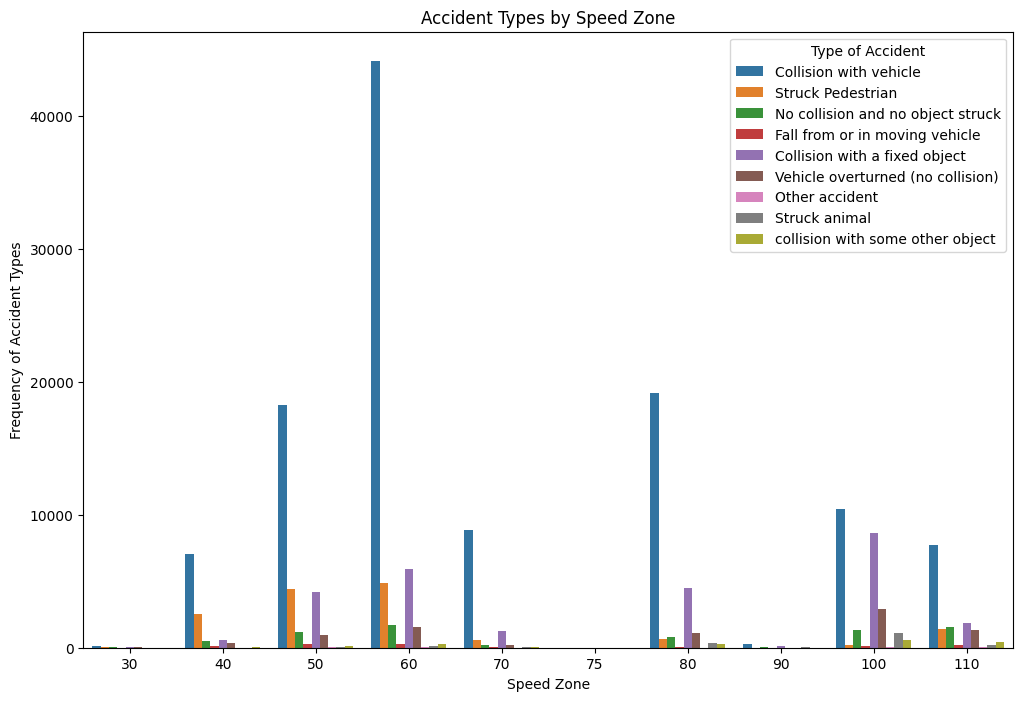

In [48]:
plt.figure(figsize=(12, 8))
sns.countplot(x='SPEED_ZONE', hue='ACCIDENT_TYPE_DESC', data=accident)
plt.title('Accident Types by Speed Zone')
plt.xlabel('Speed Zone')
plt.ylabel('Frequency of Accident Types')
plt.legend(title='Type of Accident', loc='upper right')
plt.show()

### Bar Chart Analysis of Accident Types by Speed Zone

This bar chart provides a comprehensive view of the frequency of various types of road accidents across different speed zones. Each color represents a different type of accident, allowing for a clear comparison of accident dynamics within specific speed limits. Here are some notable observations and insights drawn from this visualization:

#### Observations:
- **Predominant Accident Types**: The chart shows that 'Collision with vehicle' is the most frequent type of accident across most speed zones, particularly pronounced in the 60 km/h zone.
  
- **High Incidence in 60 km/h Zones**: A significant number of accidents occur in the 60 km/h speed zone, which is commonly found in urban areas where both vehicle and pedestrian traffic are dense. This zone shows a high frequency of 'Collision with vehicle' and 'Collision with a fixed object'.

- **Variability Across Speed Zones**: As the speed limit increases, the types of accidents change:
  - Lower speed zones (30-50 km/h) have a higher frequency of accidents involving pedestrians ('Struck Pedestrian') and fixed objects.
  - Mid-range speed zones (60-80 km/h) show a predominance of collisions with other vehicles.
  - Higher speed zones (100-110 km/h) see an increase in accidents where no collision occurs, such as vehicle overturns, suggesting that higher speeds may lead to loss of vehicle control.

- **Special Cases in Lower and Higher Speed Zones**: Accidents like 'Struck animal' and 'Vehicle overturned (no collision)' occur more frequently in higher speed zones (90 km/h and above), indicating the impact of higher speeds on accident severity and type.

#### Implications:
- **Urban Safety Measures**: The high frequency of collisions with vehicles and fixed objects in lower to mid-range speed zones suggests a need for improved urban traffic management and safety measures, such as better signage, enhanced road markings, and stricter speed enforcement.
  
- **Rural and Highway Safety**: The data indicates that higher speed zones, often found on highways and rural roads, require different safety interventions, like improved road conditions and better animal crossing management.





#Count of Accidents by Time of Day

In [53]:
# Extract hour from the datetime object
accident['HOUR'] = accident['ACCIDENT_DATE'].dt.hour

# Function to categorize time into parts of the day
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Apply the function
accident['TIME_OF_DAY'] = accident['HOUR'].apply(categorize_time_of_day)

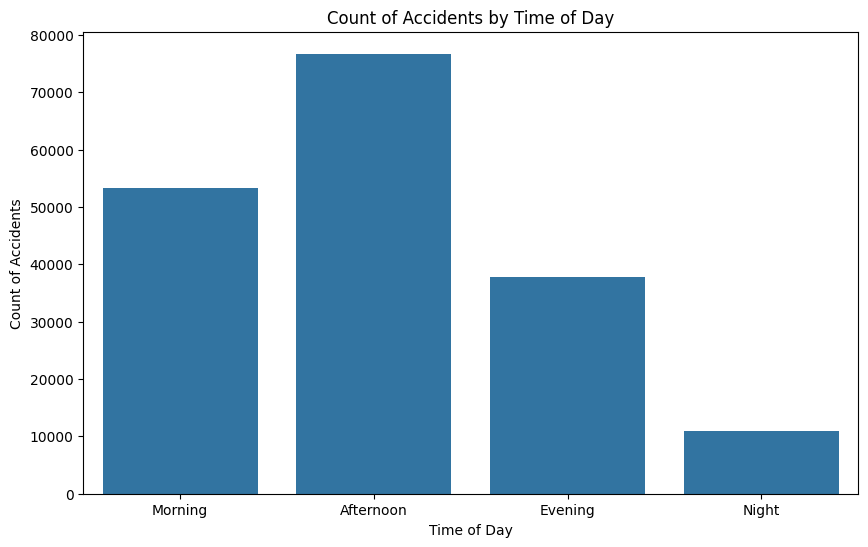

In [56]:

plt.figure(figsize=(10, 6))
sns.countplot(x='TIME_OF_DAY', data=accident, order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title('Count of Accidents by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Count of Accidents')
plt.show()




### Bar Chart Analysis of Accident Frequency by Time of Day

This bar chart presents the frequency of road accidents at different times of the day, clearly indicating how accident occurrence varies throughout the day. Each bar represents the count of accidents during a specific time period, providing insights into when accidents are most and least likely to occur. Here are some key observations from this visualization:

#### Observations:
- **Afternoon Peak**: The highest number of accidents occur in the afternoon, which might correspond with higher traffic volumes as people are either still at work or beginning to commute home. This peak suggests that the increased vehicular activity during these hours contributes to a higher risk of accidents.

- **Morning Activity**: The morning shows a significant amount of accidents, likely correlating with the morning rush hour when people are commuting to work or school. Although substantial, the frequency is notably less than in the afternoon, which could be due to different traffic patterns or perhaps more cautious driving as people start their day.

- **Evening Decrease**: There is a noticeable drop in the number of accidents during the evening hours. This decline could be attributed to reduced traffic as the night progresses, although it might still be relatively high due to factors such as reduced visibility or the possible influence of alcohol as people leave social events.

- **Nighttime Low**: The lowest frequency of accidents is observed at night. The reduced traffic volume during these late hours likely contributes to this lower count, along with fewer distractions and less activity on the roads.

#### Implications for Road Safety:
- **Targeted Safety Measures**: Understanding that the afternoon and morning are high-risk times can assist in deploying targeted safety measures, such as increased traffic monitoring and enforcement during these peak hours.
  
- **Public Awareness Campaigns**: Campaigns to raise awareness about safe driving practices could be timed to air in the mornings and afternoons to remind drivers to maintain safe driving habits during these high-risk periods.

- **Infrastructure Adjustments**: Improvements in road infrastructure, such as better lighting and more visible signage, might be particularly effective if focused on evening and night times to help reduce accidents during these hours.





#Road Geometry vs. Type of Accident

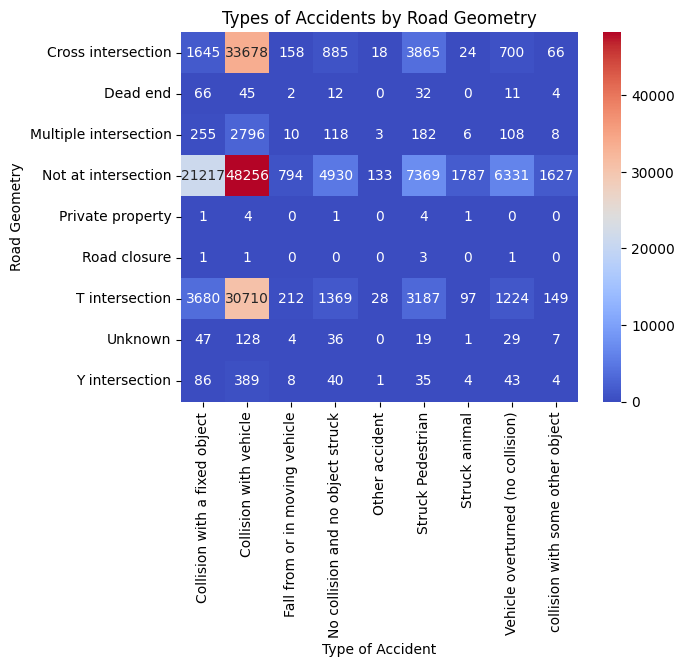

In [57]:
pivot_geo = pd.pivot_table(data=accident, values='ACCIDENT_NO', index='ROAD_GEOMETRY_DESC', columns='ACCIDENT_TYPE_DESC', aggfunc='count', fill_value=0)
sns.heatmap(pivot_geo, annot=True, fmt="d", cmap='coolwarm')
plt.title('Types of Accidents by Road Geometry')
plt.xlabel('Type of Accident')
plt.ylabel('Road Geometry')
plt.show()

### Heatmap Analysis of Accident Types by Road Geometry

This heatmap provides an insightful visual representation of the frequency of various types of accidents across different road geometries. Each cell's color intensity corresponds to the number of accidents, with warmer colors representing higher frequencies. The heatmap allows us to discern patterns and trends about where and how different types of accidents occur. Below are some key observations and insights from this visualization:

#### Key Observations:
- **High Frequency at Non-Intersections**: The most common accident type, 'Collision with vehicle', occurs predominantly at locations not at intersections, suggesting that open roads or segments between intersections are critical areas for such accidents.

- **T-Intersections**: This geometry also shows a high occurrence of 'Collision with vehicle' accidents, highlighting it as a particularly hazardous type of intersection for vehicle collisions.

- **Cross Intersections**: Similarly, cross intersections are notable hotspots for 'Collision with vehicle' and also for 'Collision with a fixed object'. This might indicate the complex nature of these intersections, where multiple pathways converge, increasing the likelihood of collisions.

- **Y-Intersections and Multiple Intersections**: These areas show relatively lower frequencies of the most severe accident types but are still significant for 'Collision with vehicle'.

- **Specific Accidents in Specific Geometries**: Certain types of accidents like 'Vehicle overturned (no collision)' and 'Struck animal' are relatively rare and show low frequencies across all road geometries, suggesting that these accident types are less influenced by road geometry compared to others.

#### Implications for Road Safety:
- **Intersection Control**: The data suggests that enhancing control and visibility at T-intersections and cross intersections could significantly reduce the frequency of vehicle collisions.
  
- **Safety Measures for Non-Intersection Areas**: Since a high volume of collisions occurs at non-intersection segments, focusing on speed management and road condition monitoring in these areas could help mitigate accidents.

- **Targeted Interventions**: Understanding that specific accident types are prevalent in specific geometries allows for more targeted interventions, such as improving signage, signal timing adjustments, and pedestrian crosswalk enforcement at intersections.




##Some Questions we could answer


#1.Which accident types are most likely to result in police attendance?

In [63]:
accident.POLICE_ATTEND.value_counts()

,count
POLICE_ATTEND,
1,132164
2,45901
9,630


It appears from the output that the POLICE_ATTEND column in the dataset is not binary but categorical, with possibly 1 indicating police attendance, 2 potentially indicating no attendance, and 9 perhaps representing unknown or missing data. Before proceeding with the analysis, it's important to clarify what each code represents. Assuming the meanings I suggested are correct, we'll adjust the data processing to handle these values appropriately.

In [64]:
# Recode the POLICE_ATTEND column
accident['POLICE_ATTEND'] = accident['POLICE_ATTEND'].replace({1: 'Attended', 2: 'Not Attended', 9: 'Unknown'})

# Calculate the proportion of each type where police attended
police_attendance = accident[accident['POLICE_ATTEND'] == 'Attended'].groupby('ACCIDENT_TYPE_DESC').size()
total_accidents = accident.groupby('ACCIDENT_TYPE_DESC').size()
attendance_rate = (police_attendance / total_accidents).reset_index(name='Attendance Rate')

# Sorting by attendance rate
attendance_rate = attendance_rate.sort_values(by='Attendance Rate', ascending=False)


In [65]:
attendance_rate

,ACCIDENT_TYPE_DESC,Attendance Rate
0,Collision with a fixed object,0.902326
5,Struck Pedestrian,0.757485
1,Collision with vehicle,0.735869
7,Vehicle overturned (no collision),0.640701
8,collision with some other object,0.549062
6,Struck animal,0.534896
2,Fall from or in moving vehicle,0.466330
4,Other accident,0.453552
3,No collision and no object struck,0.433636


<ipython-input-66-c9d95817c57c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Attendance Rate', y='ACCIDENT_TYPE_DESC', data=attendance_rate, palette='coolwarm')


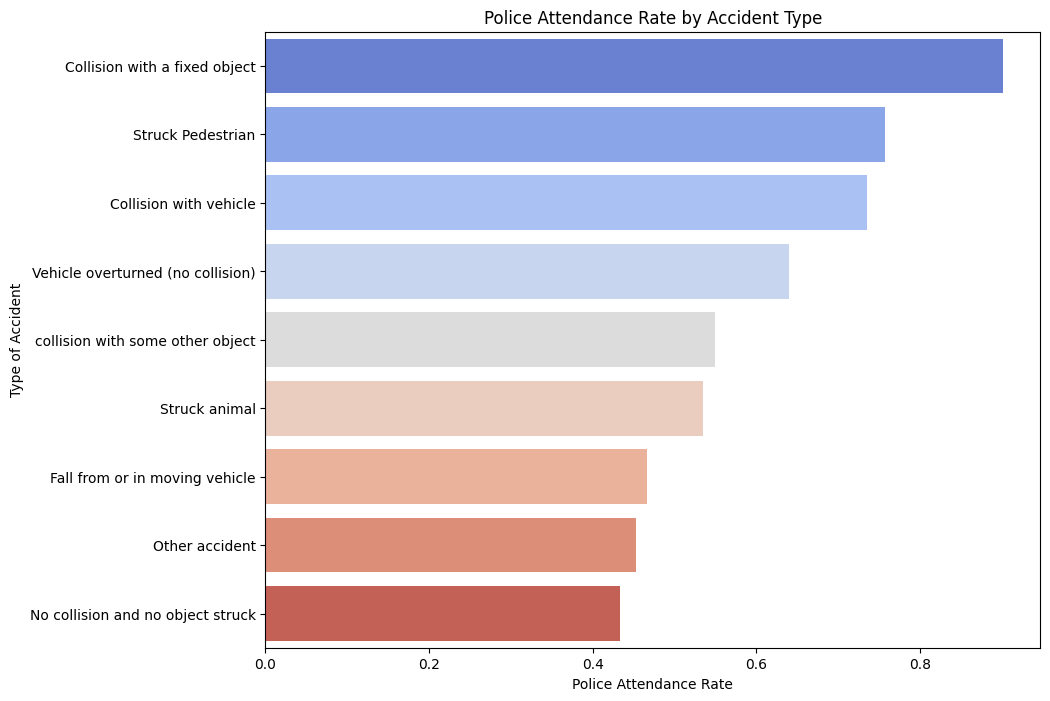

In [66]:

plt.figure(figsize=(10, 8))
sns.barplot(x='Attendance Rate', y='ACCIDENT_TYPE_DESC', data=attendance_rate, palette='coolwarm')
plt.title('Police Attendance Rate by Accident Type')
plt.xlabel('Police Attendance Rate')
plt.ylabel('Type of Accident')
plt.show()


### Bar Chart Analysis of Police Attendance Rate by Accident Type

This bar chart illustrates the rate at which police attend different types of road accidents. The length of each bar represents the proportion of accidents of that type where police attended the scene, providing insights into which accident scenarios are most likely to involve police intervention. Below are some key observations from this visualization:

#### Key Observations:
- **High Attendance in Serious Accidents**: Police attendance is most frequent in accidents involving 'Collision with a fixed object' and 'Struck Pedestrian'. These types of accidents are typically serious and may involve significant injuries or fatalities, thus requiring police intervention.

- **Moderate Attendance in Vehicle Collisions**: Accidents categorized as 'Collision with vehicle' also see a high rate of police attendance, likely due to the legal requirements for reporting and the potential for disputes or significant property damage.

- **Lower Attendance in Less Severe Accidents**: Accidents such as 'Vehicle overturned (no collision)' and 'Collision with some other object' have moderate to lower police attendance rates. These incidents might be less likely to result in injuries or may occur in less trafficked areas.

- **Very Low Attendance in Minor or Non-Traditional Accidents**: The least attended accidents by police include 'No collision and no object struck' and 'Other accident', which may involve scenarios where the incident is minor or does not typically require police on the scene, such as single-vehicle accidents with no property damage.

#### Implications for Road Safety:
- **Resource Allocation**: Understanding which types of accidents commonly require police can help allocate resources more effectively, ensuring that police are available for serious accidents where their presence is crucial.

- **Policy and Training**: The data suggests potential areas for policy improvement and targeted training for responding officers, particularly in managing serious accidents like those involving pedestrians or fixed objects.

- **Public Awareness**: Highlighting the types of accidents that frequently involve police can also inform public awareness campaigns, potentially deterring risky behaviors by emphasizing the legal and safety consequences of such accidents.




#2.How does vehicle speed impact the number and severity of accidents across different road types?

In [67]:
# Checking and cleaning data if necessary
print(accident['SPEED_ZONE'].unique())
print(accident['RMA'].unique())

[ 60 100  80 110  50  70  40  30  75  90]
['Arterial Other' nan 'Local Road' 'Arterial Highway' 'Freeway'
 'Non Arterial']


In [74]:
#categorizing nan data as unknown

print("Null Values in RMA:",accident['RMA'].isnull().sum())


Null Values in RMA: 8644


In [75]:
# Replacing NaN with 'Unknown'
accident['RMA'].fillna('Unknown', inplace=True)
print("Data after categorizing as 'Unknown':", accident['RMA'].isnull().sum())


Data after categorizing as 'Unknown': 0


<ipython-input-75-4a9768866004>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  accident['RMA'].fillna('Unknown', inplace=True)


After handling the missing data, it's good to visually or quantitatively check the distribution of the RMA column:

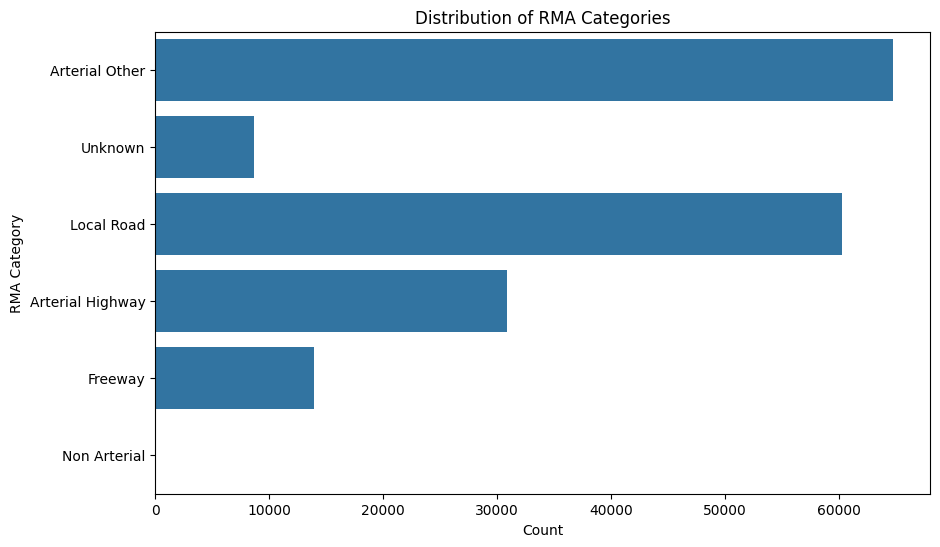

In [76]:
# Checking the distribution of RMA categories
plt.figure(figsize=(10, 6))
sns.countplot(y='RMA', data=accident)
plt.title('Distribution of RMA Categories')
plt.xlabel('Count')
plt.ylabel('RMA Category')
plt.show()

In [77]:
# Aggregating data to see the count and average severity by speed zone and RMA
agg_data = accident.groupby(['SPEED_ZONE', 'RMA']).agg(
    Accident_Count=('ACCIDENT_NO', 'count'),
    Average_Severity=('SEVERITY', 'mean')
).reset_index()

# Sorting the data for better readability/analysis
agg_data.sort_values(by=['SPEED_ZONE', 'RMA'], inplace=True)


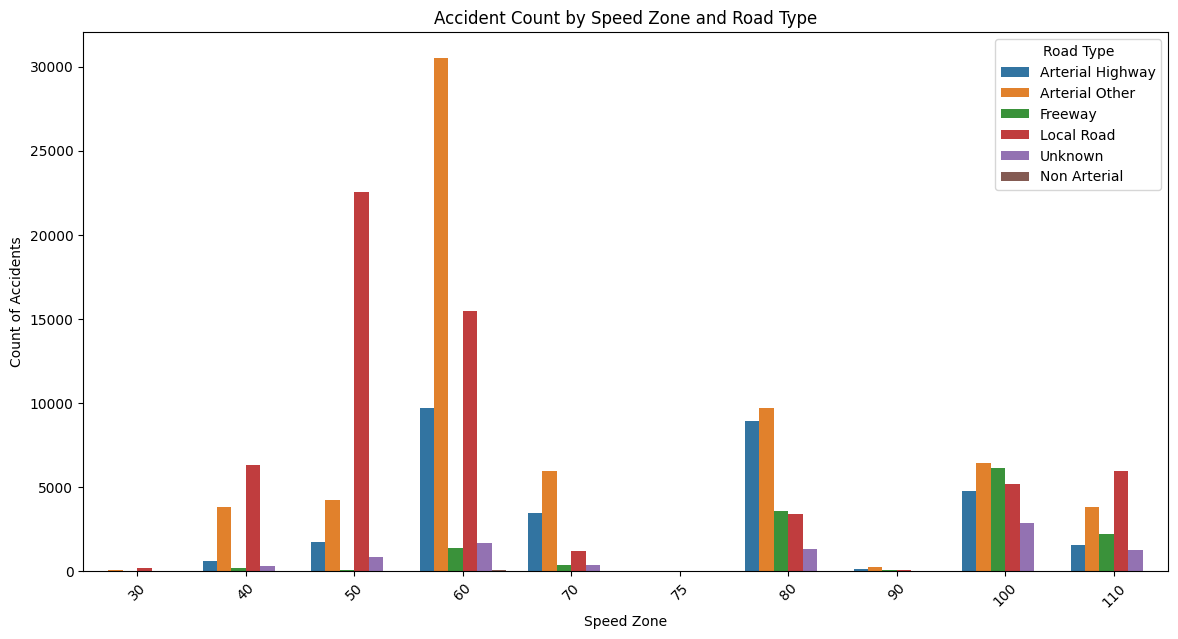

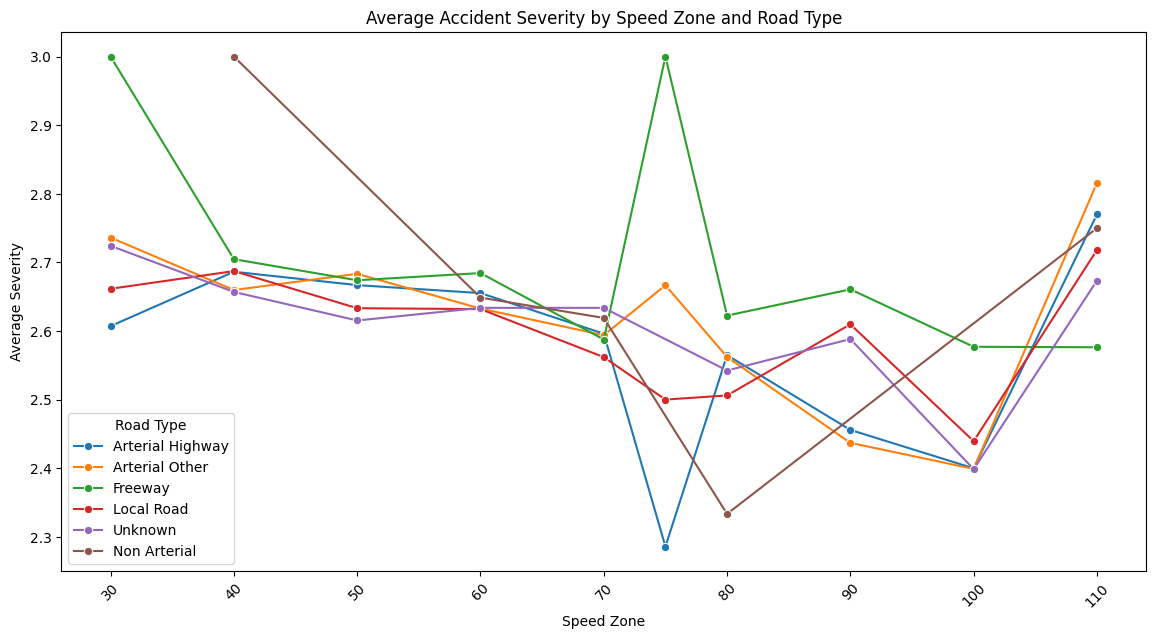

In [78]:
# Plotting accident count by speed zone and RMA
plt.figure(figsize=(14, 7))
sns.barplot(x='SPEED_ZONE', y='Accident_Count', hue='RMA', data=agg_data)
plt.title('Accident Count by Speed Zone and Road Type')
plt.xlabel('Speed Zone')
plt.ylabel('Count of Accidents')
plt.legend(title='Road Type')
plt.xticks(rotation=45)
plt.show()

# Plotting average severity by speed zone and RMA
plt.figure(figsize=(14, 7))
sns.lineplot(x='SPEED_ZONE', y='Average_Severity', hue='RMA', marker='o', data=agg_data)
plt.title('Average Accident Severity by Speed Zone and Road Type')
plt.xlabel('Speed Zone')
plt.ylabel('Average Severity')
plt.legend(title='Road Type')
plt.xticks(rotation=45)
plt.show()



### Analysis of Accident Count and Severity by Speed Zone and Road Type

The two graphs above provide insights into the relationship between vehicle speed, road type, and accident trends. These insights can help identify high-risk zones and guide traffic safety measures.

#### **1. Accident Count by Speed Zone and Road Type**
- The **highest number of accidents** occur in the **50 km/h and 60 km/h speed zones**, particularly on **local roads and arterial roads**.
- **Local Roads** have the most accidents in the **50 km/h speed zone**, indicating that urban environments with dense traffic and frequent stops contribute to more collisions.
- **Arterial Roads (Other)** experience the most accidents in the **60 km/h speed zone**, suggesting higher-speed urban roads still pose significant risks.
- Accidents in **higher speed zones (100 km/h - 110 km/h)** occur more frequently on **freeways and non-arterial roads**, though the total count is significantly lower than in urban areas.
- The **lowest number of accidents** are seen in the **30 km/h zone**, possibly because these zones are in areas with strict speed control (e.g., school zones).

##### **Implications:**
- **Urban areas (50-60 km/h zones) are high-risk locations** for accidents, requiring targeted road safety measures such as speed enforcement, better signage, and pedestrian protection strategies.
- **Highways (100-110 km/h zones) have fewer accidents**, but they may be more severe, as shown in the second graph.

---

#### **2. Average Accident Severity by Speed Zone and Road Type**
- **Severity is highest at the extremes of speed zones (30 km/h and 110 km/h)**, particularly on **freeways and non-arterial roads**.
- **Severity decreases in mid-range speed zones (50-80 km/h)**, especially on **arterial roads and local roads**, suggesting that urban traffic control measures may help reduce the severity of accidents.
- The **freeway category shows spikes in severity at lower speeds (30 km/h) and at high speeds (100 km/h - 110 km/h)**, indicating that accidents at these speeds tend to be more severe, likely due to factors like abrupt stops, lane changes, and high-impact collisions.
- **Unstable trends in severity** across speed zones suggest that other factors (e.g., weather, road conditions, traffic volume) may influence accident severity beyond just speed.

##### **Implications:**
- **Lower-speed accidents can still be severe**, possibly due to pedestrian involvement in urban areas.
- **High-speed accidents on freeways are particularly dangerous**, requiring improved highway safety measures such as better lighting, stricter speed enforcement, and improved barriers.
- **Non-arterial roads and highways at extreme speeds (low or high) require special attention** as they tend to show the most severe accident
